# Distinguishing Birds from Airplanes using the CIFAR10 dataset
- A simple classifier to distinguish birds from airplanes using the CIFAR10 dataset using mainly Pytorch
- Hyperparameter tuning has been done only for the learning rate and the regularisation factor (momentum will be done later)
- Optimizer: Adam with default parameters
- Testing was done using the CIFAR10 test_dataset, but only using accuracy as a metric. Recall, Precision and F1 score should also be done since this is a classifier
- Readings have been plotted using **TensorBoard**
- Saved models can be found under [Models](models)
- The project has been created to show familiarity with the framework and basic concepts of deep learning, for an interview I had last year

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import tensor
from torch import optim
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms
import PIL
import matplotlib.pyplot as plt


import datetime
import time
import random
import math

import os
import shutil

# Import CIFAR
from torchvision import datasets

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
import torch.utils.tensorboard

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
# Device
device = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Training on the device {device}")

Training on the device cuda


In [4]:
data_path = '../data-unversioned/p1ch7'
cifar10 = datasets.CIFAR10(data_path, train= True,download=True, transform= transforms.ToTensor())
cifar10_val = datasets.CIFAR10(data_path,train=False, download= True, transform= transforms.ToTensor())

# Building the dataset:
# Birds will be 1, Airplanes will be 0
label_map = {0: 0, 2: 1}
cifar2 = [(img, label_map[label]) for img, label, in cifar10 if label in label_map.keys()]
cifar2_val = [(img, label_map[label]) for img, label, in cifar10_val if label in label_map.keys()]

Extracting ../data-unversioned/p1ch7/cifar-10-python.tar.gz to ../data-unversioned/p1ch7
Files already downloaded and verified



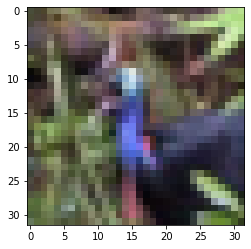

In [5]:
# Image visualisation
plt.imshow(cifar2[3][0].permute(1,2,0))
plt.show()

In [6]:
# Model
class BirdAirplaneClassifier(nn.Module):
  def __init__(self, n_chans=32):
    super().__init__()
    self.n_chans = n_chans
    self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1)
    self.batch_norm1 = nn.BatchNorm2d(n_chans)
    self.conv2 = nn.Conv2d(n_chans, n_chans // 2, kernel_size = 3, padding=1)
    self.batch_norm2 = nn.BatchNorm2d(n_chans // 2 )
    self.fc1 = nn.Linear(8 * 8 * n_chans // 2, 32)
    self.fc2 = nn.Linear(32, 2)
    self.activation = torch.tanh

  def forward(self, x):
    out = self.batch_norm1(self.conv1(x))
    out = F.max_pool2d(self.activation(out), 2)
    out = self.batch_norm2(self.conv2(out))
    out = F.max_pool2d(self.activation(out), 2)

    out = out.view (-1, 8 * 8 * self.n_chans // 2)
    out = self.activation(self.fc1(out))
    out = self.fc2(out)
    return out

In [7]:
# Calculate Accuracy
def accuracy(model, train_loader, val_loader, loss_fn, epoch, writer=None):
  to_return = ""

  with torch.no_grad():
    correct = 0
    total = 0
    val_acc = 0
    train_acc = 0

    for name, loader in [("train",train_loader), ("val", val_loader)]:
      for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        #  Calculate accuracy
        outputs = model(imgs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

      if name == "train":
        train_acc = correct/total
      else:
        val_acc = correct/total

    # Write
    if writer != None:
      writer.add_scalars("Acc",{"train_acc":train_acc,
                                "val_acc": val_acc},epoch)
      
    return {"train_acc": train_acc, "val_acc": val_acc}

In [8]:
# Main Training Routine
# Tuning: Plot training and validation loss and accuracy under hparams
def train(epochs, optimizer, model, loss_fn, train_loader, val_loader, print_int = 10, writer=None, tuning=False):
  model = model.to(device)

  for epoch in range(1, epochs + 1):
    loss_train = 0.0
    loss_val = 0.0
    acc_metric = {}

    for imgs, labels in train_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)

      predictions = model(imgs)
      loss = loss_fn(predictions, labels) 

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Training Loss
      loss_train += loss.item()

    # Validation Loss
    with torch.no_grad():
      for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        predictions = model(imgs)
        loss_val += loss_fn(predictions, labels).item()
      assert torch.no_grad()

    acc_str =''
    if epoch == 1 or epoch % print_int == 0:
      acc_metric = accuracy(model, train_loader, val_loader, loss_fn, epoch, writer)

      for key in acc_metric.keys():
        acc_str += f"{key}: {acc_metric[key]:.2f} "

      to_print = f"{datetime.datetime.now()} Epoch {epoch}/{epochs}, cost: {loss_train/len(train_loader)}, val_loss: {loss_val/len(val_loader)}, {acc_str}"
      print(to_print)

    if writer != None:
      writer.add_scalars('Loss', {"train": loss_train,
                                  "val": loss_val}, epoch)
      writer.flush()

  # For hyperparameter tuning
  if tuning:
    dir = "hparam"
    return {f"{dir}/train_loss": loss_train, 
            f"{dir}/val_loss": loss_val, 
            f"{dir}/train_acc": acc_metric["train_acc"], 
            f"{dir}/val_acc": acc_metric["val_acc"] }

# Babysitting the Learning Process

In [9]:
# Ensure the model is sain, by overfitting
# Use small dataset with many epochs
# Regularisation is set to 0
def overfit_model():
  s_train_loader = DataLoader(cifar2[:20]);
  s_val_loader = DataLoader(cifar2_val[:20])
  model = BirdAirplaneClassifier()
  loss_fn = nn.CrossEntropyLoss()
  learning_rate = 1e-4

  optimizer = optim.Adam(model.parameters(),lr=learning_rate, weight_decay=0)

  train(
      epochs=200,
      optimizer = optimizer,
      model = model,
      loss_fn = loss_fn,
      train_loader = s_train_loader,
      val_loader = s_val_loader,
      writer = SummaryWriter("runs/Babysitting")
  )

In [10]:
overfit_model()

2021-02-20 09:10:07.674633 Epoch 1/200, cost: 0.6584489181637764, val_loss: 0.7630436033010483, train_acc: 0.70 val_acc: 0.57 
2021-02-20 09:10:08.419853 Epoch 10/200, cost: 0.1841941699385643, val_loss: 0.7692034102976322, train_acc: 1.00 val_acc: 0.80 
2021-02-20 09:10:09.254293 Epoch 20/200, cost: 0.06003859108313918, val_loss: 0.8139997318387031, train_acc: 1.00 val_acc: 0.82 
2021-02-20 09:10:10.077567 Epoch 30/200, cost: 0.02842796463519335, val_loss: 0.8673792693763971, train_acc: 1.00 val_acc: 0.82 
2021-02-20 09:10:10.907506 Epoch 40/200, cost: 0.016830308153294025, val_loss: 0.9148067591711879, train_acc: 1.00 val_acc: 0.82 
2021-02-20 09:10:11.738144 Epoch 50/200, cost: 0.011263304855674505, val_loss: 0.9581077796407044, train_acc: 1.00 val_acc: 0.82 
2021-02-20 09:10:12.563403 Epoch 60/200, cost: 0.008124795265030117, val_loss: 0.9969926822930575, train_acc: 1.00 val_acc: 0.82 
2021-02-20 09:10:13.393543 Epoch 70/200, cost: 0.006156454107258469, val_loss: 1.0325919520109892

# Hyperparameter Optimisation

In [11]:
# Specifications for training
train_loader = DataLoader(cifar2, batch_size=64, shuffle= True)
val_loader = DataLoader(cifar2_val, batch_size=64, shuffle= False)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

In [12]:
# Run training routin given a learning rate (lr) and regularisation factor (reg)
def lr_reg_optimizer(lr, reg):
  model = BirdAirplaneClassifier()
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
  
  hparam = {"lr": lr, "reg": reg}

  print(f"Lr: {lr} Reg: {reg}")
  metrics = train(
    epochs=10,
    optimizer=optimizer,
    model= model,
    loss_fn=loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    print_int = 10,
    writer = None,
    tuning=True)
  
  return (hparam, metrics)

In [13]:
# Run training routine given a range of learning rates and regularisation routines
# Values are chosen at random 
def run_tuning(epochs, lr_s=(-5,5), reg_s=(-3,-6)):
  writer = SummaryWriter("runs/lr_reg")
  for count in range(epochs+1):
    lr = 10**random.uniform(*lr_s)
    reg = 10**random.uniform(*reg_s)

    print(f"({count}/{epochs})")
    logs = lr_reg_optimizer(lr=lr, reg=reg)
    writer.add_hparams(*logs)

  writer.flush()
  writer.close()

In [ ]:
run_tuning(100)

(0/100)
Lr: 0.567650998256617 Reg: 7.867857491013543e-05
2021-02-15 18:34:22.031222 Epoch 1/10, cost: 1.5850265979007552, val_loss: 1.4219716414809227, train_acc: 0.50 val_acc: 0.50 
2021-02-15 18:34:28.225759 Epoch 10/10, cost: 2.505877216150806, val_loss: 1.6791978105902672, train_acc: 0.50 val_acc: 0.50 
(1/100)
Lr: 338.84331668899966 Reg: 2.956386119840249e-06
2021-02-15 18:34:29.243472 Epoch 1/10, cost: 2521.866651170952, val_loss: 2188.830005645752, train_acc: 0.50 val_acc: 0.50 
2021-02-15 18:34:35.611080 Epoch 10/10, cost: 1219.375194074242, val_loss: 2047.9346199035645, train_acc: 0.50 val_acc: 0.50 
(2/100)
Lr: 5.3833282862544176e-05 Reg: 6.891993922103995e-05
2021-02-15 18:34:36.654628 Epoch 1/10, cost: 0.5016464205684176, val_loss: 0.43754862900823355, train_acc: 0.80 val_acc: 0.81 
2021-02-15 18:34:42.897589 Epoch 10/10, cost: 0.2921809824598823, val_loss: 0.30974658858031034, train_acc: 0.88 val_acc: 0.87 
(3/100)
Lr: 804.3093785686747 Reg: 0.00021259860531624273
2021-02-

In [ ]:
lr = math.log10(0.0011863)
run_tuning(50, lr_s=(lr,lr), reg_s=(math.log10(0.000010552),math.log10(0.000015013)))

(0/50)
Lr: 0.0011863 Reg: 1.3534334571744408e-05
2021-02-15 19:00:46.770801 Epoch 1/10, cost: 0.3799357696133814, val_loss: 0.3397082663141191, train_acc: 0.87 val_acc: 0.86 
2021-02-15 19:00:53.395962 Epoch 10/10, cost: 0.1508263599151259, val_loss: 0.27446932322345674, train_acc: 0.96 val_acc: 0.94 
(1/50)
Lr: 0.0011863 Reg: 1.3835537323377932e-05
2021-02-15 19:00:54.382887 Epoch 1/10, cost: 0.3866941856730516, val_loss: 0.3524814238771796, train_acc: 0.85 val_acc: 0.85 
2021-02-15 19:01:00.875826 Epoch 10/10, cost: 0.13898656166093365, val_loss: 0.2564171764533967, train_acc: 0.96 val_acc: 0.95 
(2/50)
Lr: 0.0011863 Reg: 1.4962744500000637e-05
2021-02-15 19:01:01.963743 Epoch 1/10, cost: 0.3884017639289236, val_loss: 0.3384848930872977, train_acc: 0.86 val_acc: 0.86 
2021-02-15 19:01:08.125161 Epoch 10/10, cost: 0.15749362175157117, val_loss: 0.2576418952085078, train_acc: 0.96 val_acc: 0.94 
(3/50)
Lr: 0.0011863 Reg: 1.1027678284811846e-05
2021-02-15 19:01:09.050656 Epoch 1/10, cos

In [39]:
# Hyperparameters:
reg = 0.000010552
lr = 0.0011863 

In [40]:
# Save file given path to drive's content directory
def save_dir(path):
  shutil.copytree(os.listdir(path),os.listdir("/content/drive"))

# Training

In [42]:
# Call the training routing with static hyperparameters as chosen above
# If model is not provided a new model is obj is created
def train_model(n_epochs=100, model=None):
  # Specifications for training
  train_loader = DataLoader(cifar2, batch_size=64, shuffle= True)
  val_loader = DataLoader(cifar2_val, batch_size=64, shuffle= False)
  
  model = model
  if model == None:
    model = BirdAirplaneClassifier()
  else:
    model = model.copy()

  loss_fn = nn.CrossEntropyLoss()

  # reg = 0.000010552
  # lr = 0.0011863

  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    
  train(
    epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader = train_loader,
    val_loader = val_loader,
    print_int = 5,
    writer = SummaryWriter("runs/Training")
  )
  torch.save(model.state_dict(), time.strftime("%Y%m%d-%H%M%S") + '_birds_from_airplanes.pt')

In [43]:
train_model(200)

2021-02-20 09:56:42.068331 Epoch 1/200, cost: 0.39295317318029466, val_loss: 0.32455219188705087, train_acc: 0.86 val_acc: 0.86 
2021-02-20 09:56:44.999265 Epoch 5/200, cost: 0.23889059730016501, val_loss: 0.275973972864449, train_acc: 0.91 val_acc: 0.91 
2021-02-20 09:56:48.565845 Epoch 10/200, cost: 0.14652584633155233, val_loss: 0.26974772615358233, train_acc: 0.96 val_acc: 0.94 
2021-02-20 09:56:52.119385 Epoch 15/200, cost: 0.0855239766537194, val_loss: 0.29206226114183664, train_acc: 0.97 val_acc: 0.96 
2021-02-20 09:56:55.644905 Epoch 20/200, cost: 0.03861371154902847, val_loss: 0.33976264321245253, train_acc: 0.99 val_acc: 0.98 
2021-02-20 09:56:59.201407 Epoch 25/200, cost: 0.03399816056072807, val_loss: 0.3338632481172681, train_acc: 1.00 val_acc: 0.98 
2021-02-20 09:57:02.773781 Epoch 30/200, cost: 0.019587520478815314, val_loss: 0.42801597574725747, train_acc: 0.99 val_acc: 0.97 
2021-02-20 09:57:06.347121 Epoch 35/200, cost: 0.011512325209073105, val_loss: 0.42439689673483

In [31]:
# Test Dataset
test_dataset = datasets.CIFAR10(data_path,train=False, download= True, transform= transforms.ToTensor())
label_map = {0: 0, 2: 1}
cifar2_test = [(img, label_map[label]) for img, label, in test_dataset if label in label_map.keys()]

Files already downloaded and verified


In [58]:
# Evaluation: Get Acuracy of model using the test_dataset of cifar
def test(path_to_model):
  model = BirdAirplaneClassifier().to(device)
  model.load_state_dict(torch.load(path_to_model,map_location=device))

  model.eval()
  total_entries = len(cifar2_test)
  correct = 0.0

  with torch.no_grad():
    for entry in cifar2_test:
      img = entry[0][None].to(device)
      label = entry[1]

      #  Calculate accuracy
      outputs = model(img)
      _, predicted = torch.max(outputs, dim=1)
      correct += int((predicted == label).sum())

  print(f"Accuracy: {correct/total_entries}")    

In [56]:
test("/content/drive/MyDrive/models/20210215-193728_birds_from_airplanes.pt")

Accuracy: 0.892


In [57]:
test("/content/20210220-095903_birds_from_airplanes.pt")

Accuracy: 0.896
